In [13]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering

import networkx as nx

from scipy.cluster.hierarchy import dendrogram, linkage

In [14]:
# Hyperparameters
cuda = True
epochs = 10
log_interval = 400
batchSize = 16

hidden_layer_sizes = [3 * 32 * 32, 256, 10]

lr = 1e-3

In [15]:
def softmax(input, axis=1):
    input_size = input.size()
    
    trans_input = input.transpose(axis, len(input_size)-1)
    trans_size = trans_input.size()

    input_2d = trans_input.contiguous().view(-1, trans_size[-1])
    
    soft_max_2d = F.softmax(input_2d)
    
    soft_max_nd = soft_max_2d.view(*trans_size)
    return soft_max_nd.transpose(axis, len(input_size)-1)

In [16]:
class Attention(nn.Module):
    def __init__(self, dim):
        super(Attention, self).__init__()
        self.coefs = nn.Parameter(torch.FloatTensor(dim, dim))
        self.coefs.data.normal_(0, 1.)
        self.normal_coefs = torch.exp(-self.coefs) / torch.exp(-self.coefs).sum(1).repeat(1, dim)
    
    def forward(self, X):
        return F.linear(X, weight=self.normal_coefs)
        
    

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]) for i in range(len(hidden_layer_sizes) - 1)])
        self.attentions = nn.ModuleList([nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i] ** 2) for i in range(1, len(hidden_layer_sizes) - 1)])
        for i, l in enumerate(self.attentions):
            self.attentions[i].bias.data.copy_(torch.eye(self.attentions[i].weight.size(0)).view(-1))
            scale = .1 / torch.sqrt(self.attentions[i].weight.size(0))
            self.attentions[i].weight.data.uniform_(-scale,scale)
    
    def clamp(self, weight):
        size = int(np.sqrt(weigh.size(0)))
        weight = weight.view(size, size)
        weight.data.clamp_(0., 1.)
        weight.data.div_(self.attentions[i].sum(1).repeat(1, weight.size(0)).data)
        return weight
            
    def forward(self, x):
        activations = 0
        x = x.view(-1, 3 * 32 * 32)
        for i, l in enumerate(self.linears):
            x = F.relu(l(x))
            if i < len(self.attentions):
                weights = self.clamp(self.attentions[i](torch.sign(x)))
                x = F.linear(x, weight=weights)
            if i + 2 == len(hidden_layer_sizes):
                break
            if type(activations) is np.ndarray:
                activations = np.append(activations, np.expand_dims(torch.sign(x).cpu().data.numpy(), axis=1), axis=1)
            else:
                activations = np.expand_dims(torch.sign(x).cpu().data.numpy(), axis=1)
        return x, activations
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([
                {'params': model.linears.parameters()},
                {'params': model.attentions.parameters(), 'lr': 1e-2}
            ], lr=lr, momentum=0.9)

RuntimeError: $ Torch: not enough memory: you tried to allocate 16GB. Buy new RAM! at /py/conda-bld/pytorch_1493676237139/work/torch/lib/TH/THGeneral.c:270

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
if cuda:
    model.cuda()
    criterion.cuda()

In [8]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target) + (epoch - 1.) / 10* 10000 * model.attentions[0].abs().mean()
        loss.backward()
        optimizer.step()
        model.clamp()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


In [9]:
# activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.278446
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.182377


Process Process-2:
Process Process-1:
Traceback (most recent call last):
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
    r = index_queue.get()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/queues.py", line

KeyboardInterrupt: 

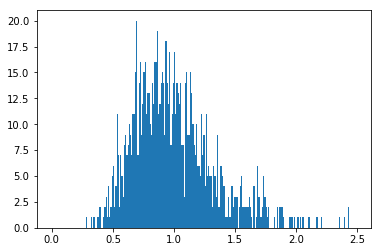

In [10]:
plt.hist(model.attentions[0].sum(0).squeeze().cpu().data.numpy(), bins=np.arange(0., 2.5, 0.01))
plt.show()

In [11]:
model.attentions[0].sum(0).squeeze()

Variable containing:
 0.8848
 0.5671
 0.9629
   ⋮   
 1.7440
 1.4152
 0.6981
[torch.cuda.FloatTensor of size 1024 (GPU 0)]